#### Drafts and Various Versions

##### imports and configurations

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from torch.utils.data import Dataset, DataLoader, random_split
from pathlib import Path
import os
import glob
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
drive.mount('/content/drive')
#os.chdir('/MyDrive/SSAST')

# Check if GPU is available (likely CPU if local, which is fine for debugging)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Mounted at /content/drive
Using device: cuda


##### Version 1

In [ ]:
import os
from pydub import AudioSegment
from pydub.exceptions import CouldntDecodeError
from tqdm import tqdm

# 🔹 FFmpeg setup
#ffmpeg_dir = r"C:\ffmpeg\bin"
#os.environ["PATH"] += os.pathsep + ffmpeg_dir
#AudioSegment.converter = os.path.join(ffmpeg_dir, "ffmpeg.exe")
#AudioSegment.ffprobe   = os.path.join(ffmpeg_dir, "ffprobe.exe")

# 🔹 Dataset paths
input_dataset = "./data/genres_original"
output_dataset = "./data/gtzan_10s_1"
segment_length = 10 * 1000  # 10 seconds in milliseconds

os.makedirs(output_dataset, exist_ok=True)
genres = [g for g in os.listdir(input_dataset) if os.path.isdir(os.path.join(input_dataset, g))]

# Dictionary to store counts per genre
genre_counts = {}

for genre in genres:
    genre_path = os.path.join(input_dataset, genre)
    out_dir = os.path.join(output_dataset, genre)
    os.makedirs(out_dir, exist_ok=True)

    print(f"\nProcessing genre: {genre}")
    count = 0
    for file in tqdm(os.listdir(genre_path)):
        if not file.endswith(".wav"):
            continue

        file_path = os.path.join(genre_path, file)
        try:
            audio = AudioSegment.from_wav(file_path)
        except CouldntDecodeError:
            print(f"⚠ Could not decode {file_path}, skipping...")
            continue

        duration = len(audio)
        for i in range(0, duration, segment_length):
            chunk = audio[i:i + segment_length]
            if len(chunk) < segment_length:
                continue  # skip short last chunk

            filename = f"{file.replace('.wav','')}_{i//segment_length}.wav"
            chunk.export(os.path.join(out_dir, filename), format="wav")
            count += 1

    genre_counts[genre] = count

# Print summary of counts
print("\n✅ Done! Summary of 10s segments per genre:")
for genre, count in genre_counts.items():
    print(f"{genre}: {count} segments")

In [ ]:
# Cell 4: Define Dataset Class
import torch
import torchaudio
import soundfile as sf
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import glob
import os

class GTZANDataset(Dataset):
    def __init__(self, data_path, target_length=1024):
        # Find all .wav files in subfolders
        self.files = sorted(glob.glob(os.path.join(data_path, "*", "*.wav")))

        # Create label mapping (rock -> 0, jazz -> 1, etc.)
        self.classes = sorted(list(set([f.split(os.sep)[-2] for f in self.files])))
        self.cls_to_idx = {c: i for i, c in enumerate(self.classes)}

        # SSAST Normalization Stats
        self.norm_mean = -4.2677393
        self.norm_std = 4.5689974
        self.target_length = target_length

    def __getitem__(self, idx):
        wav_path = self.files[idx]
        label = self.cls_to_idx[wav_path.split(os.sep)[-2]]

        # 1. Robust Load using SoundFile
        # This avoids the "No backend" error you saw earlier
        audio_np, sr = sf.read(wav_path)
        waveform = torch.from_numpy(audio_np).float()

        # Ensure shape is [1, time]
        if waveform.dim() == 1:
            waveform = waveform.unsqueeze(0)

        # 2. Resample to 16kHz (Required by SSAST)
        if sr != 16000:
            waveform = torchaudio.transforms.Resample(sr, 16000)(waveform)

        # 3. Create Spectrogram (Kaldi Fbank matches paper)
        fbank = torchaudio.compliance.kaldi.fbank(
            waveform,
            htk_compat=True,
            sample_frequency=16000,
            use_energy=False,
            window_type='hanning',
            num_mel_bins=128,
            dither=0.0,
            frame_shift=10
        )

        # 4. Force Exact Length (Padding/Cropping)
        n_frames = fbank.shape[0]
        p = self.target_length - n_frames
        if p > 0:
            m = torch.nn.ZeroPad2d((0, 0, 0, p))
            fbank = m(fbank)
        elif p < 0:
            fbank = fbank[:self.target_length, :]

        # 5. Normalize
        fbank = (fbank - self.norm_mean) / (self.norm_std * 2)

        return fbank, label

    def __len__(self):
        return len(self.files)

# Verify it works
ds = GTZANDataset("./data/gtzan_10s")
print(f"✅ Dataset Ready! Found {len(ds)} samples.")
print(f"Classes: {ds.classes}")

✅ Dataset Ready! Found 2988 samples.
Classes: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [ ]:
# Cell 5: Data Loaders
from torch.utils.data import DataLoader

# 80% Train / 20% Test
train_size = int(0.8 * len(ds))
test_size = len(ds) - train_size
train_ds, test_ds = random_split(ds, [train_size, test_size])

print(f"Train Size: {len(train_ds)}")
print(f"Test Size: {len(test_ds)}")

# Batch size 16 is safe for Colab's T4 GPU
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=2)

Train Size: 2390
Test Size: 598


In [ ]:
# Cell 6: Baseline CNN Architecture
import torch.nn as nn
import torch.nn.functional as F

class BaselineCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(BaselineCNN, self).__init__()

        # 4 Conv Blocks
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(2, 2)

        # Classifier
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 64 * 8, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Add channel dimension [Batch, 1, Time, Freq]
        x = x.unsqueeze(1)

        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

✅ ResNet-18 Baseline Loaded.


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
# Cell 7: Universal Training Engine
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def train_engine(model, epochs, lr):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    history = {'acc': [], 'loss': []}

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        acc = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(train_loader):.4f} | Test Acc: {acc:.2f}%")
        history['acc'].append(acc)

    return history

Using device: cuda


In [ ]:
# Cell 8: Run Baseline Training
cnn_model = BaselineCNN(num_classes=10)
print("🚀 Training Baseline CNN...")
# Standard LR for scratch training is 0.001
cnn_history = train_engine(cnn_model, epochs=20, lr=0.001)

🚀 Training Baseline CNN...


TypeError: an integer is required

##### Version 2

In [ ]:
import os
import torch
import torchaudio
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Paths
DATASET_PATH = "/content/drive/MyDrive/SSAST/data/gtzan_10s"  # sliced 10s dataset
TARGET_SR = 16000                  # SSAST requirement
NUM_MEL_BINS = 128
FRAME_LENGTH_MS = 25
FRAME_SHIFT_MS = 10
NUM_FRAMES = 1024                  # model input length

# AudioSet statistics for normalization
AUDIOSET_MEAN = -4.2677393
AUDIOSET_STD = 4.5689974 * 2

In [ ]:
import random

class GTZANDataset(Dataset):
    def __init__(self, root_dir, apply_augment=True):
        self.file_paths = []
        self.labels = []
        self.class2idx = {}
        self.apply_augment = apply_augment  # toggle ON/OFF

        classes = sorted(os.listdir(root_dir))
        for idx, cls in enumerate(classes):
            self.class2idx[cls] = idx
            cls_dir = os.path.join(root_dir, cls)

            for file in os.listdir(cls_dir):
                if file.endswith(".wav"):
                    self.file_paths.append(os.path.join(cls_dir, file))
                    self.labels.append(idx)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        path  = self.file_paths[idx]
        label = self.labels[idx]

        # ===========================
        #  SAFE LOAD (Bad File Skip)
        # ===========================
        try:
            waveform, sr = torchaudio.load(path)
        except Exception:
            print(f"⚠ Bad file skipped: {path}")
            return torch.zeros(NUM_FRAMES, NUM_MEL_BINS), label   # keep batch intact

        # ===========================
        #   RESAMPLE → 16 kHz fixed
        # ===========================
        if sr != TARGET_SR:
            waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=TARGET_SR)(waveform)

        # ===========================
        #     KALDI FBank Extract
        # ===========================
        fbank = torchaudio.compliance.kaldi.fbank(
            waveform,
            num_mel_bins=NUM_MEL_BINS,
            frame_length=FRAME_LENGTH_MS,
            frame_shift=FRAME_SHIFT_MS
        )

        # ===========================
        #      ↪ SpecAugment ↩
        # (Before Normalization)
        # ===========================
        if self.apply_augment and random.random() < 0.5:
            fbank = torchaudio.transforms.FrequencyMasking(freq_mask_param=12)(fbank)
            fbank = torchaudio.transforms.TimeMasking(time_mask_param=12)(fbank)

        # ===========================
        #   Shape must be 1024 × 128
        # ===========================
        T = fbank.shape[0]
        if T < NUM_FRAMES:
            fbank = torch.cat([fbank, torch.zeros(NUM_FRAMES - T, NUM_MEL_BINS)], dim=0)
        else:
            fbank = fbank[:NUM_FRAMES]

        # ===========================
        #  Normalize (AudioSet spec)
        # ===========================
        fbank = (fbank - AUDIOSET_MEAN) / AUDIOSET_STD

        return fbank, label


In [ ]:
dataset = GTZANDataset(DATASET_PATH)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

BATCH_SIZE = 32
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train samples: {len(train_set)}, Validation samples: {len(val_set)}")

Train samples: 2390, Validation samples: 598


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
        )

        # FIXED FC SHAPE
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 128 * 16, 256),  # <— corrected
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.fc(self.conv_layers(x))


In [ ]:
model = SimpleCNN(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
from torch.optim.lr_scheduler import StepLR

EPOCHS = 30                           # increased training time
scheduler = StepLR(optimizer,
                   step_size=10,      # reduce LR every 10 epochs
                   gamma=0.5)         # new_lr = old_lr * 0.5

for epoch in range(EPOCHS):

    model.train()
    total_loss = 0

    for X, y in train_loader:
        X, y = X.unsqueeze(1).to(device), y.to(device)

        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)

        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X.size(0)

    avg_loss = total_loss / len(train_loader.dataset)

    # 🔥 decays LR at scheduled epochs
    scheduler.step()

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")

Epoch 1/30 | Loss: 2.1724 | LR: 0.001000
Epoch 2/30 | Loss: 2.1626 | LR: 0.001000
Epoch 3/30 | Loss: 2.1147 | LR: 0.001000
Epoch 4/30 | Loss: 2.1155 | LR: 0.001000
Epoch 5/30 | Loss: 2.0896 | LR: 0.001000
Epoch 6/30 | Loss: 2.0820 | LR: 0.001000
Epoch 7/30 | Loss: 2.0451 | LR: 0.001000
Epoch 8/30 | Loss: 2.0618 | LR: 0.001000
Epoch 9/30 | Loss: 2.0532 | LR: 0.001000
Epoch 10/30 | Loss: 2.0381 | LR: 0.000500
Epoch 11/30 | Loss: 1.9818 | LR: 0.000500
Epoch 12/30 | Loss: 1.9890 | LR: 0.000500
Epoch 13/30 | Loss: 1.9745 | LR: 0.000500
Epoch 14/30 | Loss: 1.9411 | LR: 0.000500
Epoch 15/30 | Loss: 1.9573 | LR: 0.000500
Epoch 16/30 | Loss: 1.9112 | LR: 0.000500
Epoch 17/30 | Loss: 1.9204 | LR: 0.000500
Epoch 18/30 | Loss: 1.8965 | LR: 0.000500
Epoch 19/30 | Loss: 1.8808 | LR: 0.000500
Epoch 20/30 | Loss: 1.8627 | LR: 0.000250
Epoch 21/30 | Loss: 1.8264 | LR: 0.000250
Epoch 22/30 | Loss: 1.8120 | LR: 0.000250
Epoch 23/30 | Loss: 1.8179 | LR: 0.000250
Epoch 24/30 | Loss: 1.8165 | LR: 0.000250
E

In [ ]:
# ========================================
# Cell 7: Validation Accuracy
# ========================================
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for X, y in val_loader:
        X, y = X.unsqueeze(1).to(device), y.to(device)
        outputs = model(X)
        preds = outputs.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)
print(f"Validation Accuracy: {correct/total:.4f}")


⚠ Bad file skipped: /content/drive/MyDrive/SSAST/data/gtzan_10s/reggae/reggae.00027_2.wav
Validation Accuracy: 0.3010


In [ ]:
import torchvision.models as models

def get_resnet_baseline(num_classes=10):
    # 1. Load standard ResNet-18
    model = models.resnet18(weights=None) # Train from scratch

    # 2. Modify Input Layer
    # ResNet expects 3-channel RGB. We have 1-channel Spectrograms.
    # We change the first layer to accept 1 input channel.
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

    # 3. Modify Output Layer
    # ResNet outputs 1000 classes (ImageNet). We need 10 (GTZAN).
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model

# Initialize
model = get_resnet_baseline(num_classes=10).to(device)

# Setup Training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

print("✅ ResNet-18 Baseline Loaded (approx 11M parameters).")

# --- Training Loop ---
EPOCHS = 25

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for X, y in train_loader:
        X, y = X.unsqueeze(1).to(device), y.to(device) # [Batch, 1, Time, Freq]

        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        total += y.size(0)
        correct += preds.eq(y).sum().item()

    scheduler.step()
    train_acc = 100. * correct / total
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {running_loss/len(train_loader):.4f} | Train Acc: {train_acc:.2f}%")

# --- Validation Check ---
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X, y in val_loader:
        X, y = X.unsqueeze(1).to(device), y.to(device)
        outputs = model(X)
        _, preds = outputs.max(1)
        total += y.size(0)
        correct += preds.eq(y).sum().item()

print(f"\n🏆 Final Validation Accuracy: {100. * correct / total:.2f}%")

✅ ResNet-18 Baseline Loaded (approx 11M parameters).
⚠ Bad file skipped: /content/drive/MyDrive/SSAST/data/gtzan_10s/reggae/reggae.00027_2.wav
Epoch 1/25 | Loss: 1.5859 | Train Acc: 44.56%
⚠ Bad file skipped: /content/drive/MyDrive/SSAST/data/gtzan_10s/reggae/reggae.00027_2.wav
Epoch 2/25 | Loss: 1.2755 | Train Acc: 55.48%
⚠ Bad file skipped: /content/drive/MyDrive/SSAST/data/gtzan_10s/reggae/reggae.00027_2.wav
Epoch 3/25 | Loss: 1.0668 | Train Acc: 63.77%
⚠ Bad file skipped: /content/drive/MyDrive/SSAST/data/gtzan_10s/reggae/reggae.00027_2.wav
Epoch 4/25 | Loss: 0.9157 | Train Acc: 68.66%
⚠ Bad file skipped: /content/drive/MyDrive/SSAST/data/gtzan_10s/reggae/reggae.00027_2.wav
Epoch 5/25 | Loss: 0.7983 | Train Acc: 71.63%
⚠ Bad file skipped: /content/drive/MyDrive/SSAST/data/gtzan_10s/reggae/reggae.00027_2.wav
Epoch 6/25 | Loss: 0.7006 | Train Acc: 75.52%
⚠ Bad file skipped: /content/drive/MyDrive/SSAST/data/gtzan_10s/reggae/reggae.00027_2.wav
Epoch 7/25 | Loss: 0.6372 | Train Acc: 78

##### Version 3

In [ ]:
import torch
import torchaudio
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader

class GTZAN10sDataset(Dataset):
    def __init__(self, csv_path, class_mapping, augment=False):
        self.df = pd.read_csv(csv_path)
        self.class_mapping = class_mapping
        self.augment = augment
        self.target_sr = 16000
        self.target_length = 1024 # 1024 frames corresponds to ~10.24 seconds

        # SSAST AudioSet Statistics (Required for Transfer Learning)
        self.norm_mean = -4.2677393
        self.norm_std = 4.5689974

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        audio_path = row["filepath"]
        # Ensure we get the label correctly (handle string vs int)
        label_str = row["label"]
        label = self.class_mapping[label_str] if isinstance(label_str, str) else label_str

        # 1. Load audio
        # Note: If you are on Windows and get backend errors, stick to soundfile.read()
        waveform, sr = torchaudio.load(audio_path)

        # 2. Resample to 16kHz
        if sr != self.target_sr:
            waveform = torchaudio.transforms.Resample(sr, self.target_sr)(waveform)

        # 3. Mono conversion (if needed)
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        # 4. Kaldi FBank Extraction (Matches SSAST paper exactly)
        # Replaces MelSpectrogram + AmplitudeToDB
        fbank = torchaudio.compliance.kaldi.fbank(
            waveform,
            htk_compat=True,
            sample_frequency=16000,
            use_energy=False,
            window_type='hanning',
            num_mel_bins=128,
            dither=0.0,
            frame_shift=10
        )

        # 5. Padding / Cropping to 1024 Frames
        n_frames = fbank.shape[0]
        p = self.target_length - n_frames

        if p > 0:
            # Pad with zeros if too short
            m = torch.nn.ZeroPad2d((0, 0, 0, p))
            fbank = m(fbank)
        elif p < 0:
            # Crop if too long
            fbank = fbank[0:self.target_length, :]

        # 6. Normalize using AudioSet Stats
        # The formula includes * 2 as per the SSAST repository
        fbank = (fbank - self.norm_mean) / (self.norm_std * 2)

        # Output shape is [1024, 128]
        return fbank, torch.tensor(label, dtype=torch.long)

In [ ]:
import os
from pydub import AudioSegment
from pydub.exceptions import CouldntDecodeError
from tqdm import tqdm

class_mapping = {
    "blues": 0, "classical": 1, "country": 2, "disco": 3,
    "hiphop": 4, "jazz": 5, "metal": 6, "pop": 7,
    "reggae": 8, "rock": 9
}

train_set = GTZAN10sDataset("./metadata/train.csv", class_mapping)
print(f"Number of samples: {len(train_set)}")


fbank, label = train_set[0]
print(f"Spectrogram shape: {fbank.shape}")   # Should be [NUM_FRAMES, NUM_MEL_BINS]
print(f"Label: {label}")                     # Should be an int 0–9

#### Working SSAST Implementation

version 4

In [ ]:
# Cell 1: Environment Setup
from google.colab import drive
import sys
import os
import shutil

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Install Audio Libraries (Linux System + Python)
!apt-get update -qq && apt-get install -y libsndfile1 ffmpeg > /dev/null
!pip install timm==0.4.5 torchaudio soundfile pandas matplotlib > /dev/null

print(" Environment Ready.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
 Environment Ready.


In [ ]:
# Cell 2: Transfer Data for Speed
from pathlib import Path

# --- CONFIGURATION: EDIT THIS PATH ---
# Where did you put your files in Drive?
DRIVE_PROJECT_PATH = "/content/drive/MyDrive/SSAST_Project"
# -------------------------------------

def setup_local_environment():
    print(f"Setting up from: {DRIVE_PROJECT_PATH}")

    # 1. Copy Model Code (ast_models.py) to current directory
    # This allows us to do 'from ast_models import ASTModel' easily
    if not os.path.exists('ast_models.py'):
        shutil.copy(f"{DRIVE_PROJECT_PATH}/ast_models.py", ".")
        print("Model code copied.")

    # 2. Copy Metadata CSVs
    if not os.path.exists('metadata'):
        shutil.copytree(f"{DRIVE_PROJECT_PATH}/metadata", "metadata")
        print("Metadata copied.")

    # 3. Copy Audio Data (The big one)
    # Checks if we already have it locally to save time on re-runs
    if not os.path.exists('./data/gtzan_10s'):
        print("Copying audio files from Drive to Local Disk (this is faster for training)...")
        # Ensure destination dir exists
        os.makedirs('./data', exist_ok=True)

        # Copy the folder
        shutil.copytree(f"{DRIVE_PROJECT_PATH}/data/gtzan_10s", "./data/gtzan_10s")
        print("Audio data copied successfully!")
    else:
        print("Audio data already present locally.")

setup_local_environment()

Setting up from: /content/drive/MyDrive/SSAST_Project
Model code copied.
Metadata copied.
Copying audio files from Drive to Local Disk (this is faster for training)...
Audio data copied successfully!


In [ ]:
# Cell: Data Integrity Check
import pandas as pd
import soundfile as sf
import os
from tqdm import tqdm

def check_data_health(csv_path):
    print(f"🩺 Checking health of dataset: {csv_path}")

    try:
        df = pd.read_csv(csv_path)
    except FileNotFoundError:
        print(f"Error: Could not find {csv_path}")
        return

    bad_files = []

    for idx, row in tqdm(df.iterrows(), total=len(df)):
        file_path = row['filepath']

        # 1. Check if file exists
        if not os.path.exists(file_path):
            bad_files.append((file_path, "File Not Found"))
            continue

        # 2. Check if file is empty
        if os.path.getsize(file_path) < 100: # WAV header is ~44 bytes
            bad_files.append((file_path, "File Empty (<100 bytes)"))
            continue

        # 3. Try to read audio
        try:
            sf.read(file_path)
        except Exception as e:
            # We catch the generic exception because soundfile might crash printing the specific one
            bad_files.append((file_path, "Corrupt Audio Header/Data"))

    if len(bad_files) == 0:
        print("\nDataset is HEALTHY! No corrupt files found.")
    else:
        print(f"\n FOUND {len(bad_files)} BAD FILES!")
        print("Here are the first 5 culprits:")
        for path, reason in bad_files[:5]:
            print(f"  - {path} : {reason}")

        print("\n RECOMMENDATION: Delete these files from your 'data' folder and remove them from your CSV.")

# Run check on Train and Val
check_data_health("metadata/train.csv")
check_data_health("metadata/val.csv")

🩺 Checking health of dataset: metadata/train.csv


100%|██████████| 2390/2390 [00:03<00:00, 661.01it/s]



 FOUND 1 BAD FILES!
Here are the first 5 culprits:
  - ./data/gtzan_10s/reggae/reggae.00027_2.wav : File Empty (<100 bytes)

 RECOMMENDATION: Delete these files from your 'data' folder and remove them from your CSV.
🩺 Checking health of dataset: metadata/val.csv


100%|██████████| 295/295 [00:00<00:00, 670.40it/s]


Dataset is HEALTHY! No corrupt files found.


In [ ]:
# Cell: Fix Corrupt CSV Entry
import pandas as pd

csv_path = "metadata/train.csv"
bad_file = "./data/gtzan_10s/reggae/reggae.00027_2.wav"

# Load
df = pd.read_csv(csv_path)
initial_len = len(df)

# Filter out the bad file
df = df[df['filepath'] != bad_file]

# Save back
df.to_csv(csv_path, index=False)

print(f"   Fixed {csv_path}")
print(f"   Removed: {bad_file}")
print(f"   Rows: {initial_len} -> {len(df)}")

   Fixed metadata/train.csv
   Removed: ./data/gtzan_10s/reggae/reggae.00027_2.wav
   Rows: 2390 -> 2389


In [ ]:
# Cell 3: Dataset
import pandas as pd
import torch
import torchaudio
import soundfile as sf
from torch.utils.data import Dataset, DataLoader

class GTZAN_Metadata_Dataset(Dataset):
    def __init__(self, csv_path):
        self.df = pd.read_csv(csv_path)
        self.target_sr = 16000
        self.target_length = 1024 # frames

        # Mapping from string labels to int
        self.classes = sorted(self.df['label'].unique().tolist())
        self.cls_to_idx = {c: i for i, c in enumerate(self.classes)}

        # SSAST Normalization Stats
        self.norm_mean = -4.2677393
        self.norm_std = 4.5689974

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # FIX PATH: The CSV might have "data/gtzan_10s/..." or Windows paths.
        # We enforce the local Linux path we created in Cell 2.
        filename = os.path.basename(row['filepath']) # e.g. "blues.00000_0.wav"
        label_str = row['label']
        genre_folder = label_str # Usually the folder name is the genre name

        # Construct the safe local path
        audio_path = f"./data/gtzan_10s/{genre_folder}/{filename}"

        label = self.cls_to_idx[label_str]

        # 1. Load
        audio_np, sr = sf.read(audio_path)
        waveform = torch.from_numpy(audio_np).float()
        if waveform.dim() == 1: waveform = waveform.unsqueeze(0)

        # 2. Resample
        if sr != 16000:
            waveform = torchaudio.transforms.Resample(sr, 16000)(waveform)

        # 3. Spectrogram
        fbank = torchaudio.compliance.kaldi.fbank(
            waveform, htk_compat=True, sample_frequency=16000, use_energy=False,
            window_type='hanning', num_mel_bins=128, dither=0.0, frame_shift=10
        )

        # 4. Pad/Crop
        n_frames = fbank.shape[0]
        p = self.target_length - n_frames
        if p > 0:
            m = torch.nn.ZeroPad2d((0, 0, 0, p))
            fbank = m(fbank)
        elif p < 0:
            fbank = fbank[:self.target_length, :]

        # 5. Normalize
        fbank = (fbank - self.norm_mean) / (self.norm_std * 2)

        return fbank, label

# Load Data
train_ds = GTZAN_Metadata_Dataset("metadata/train.csv")
val_ds   = GTZAN_Metadata_Dataset("metadata/val.csv")
test_ds  = GTZAN_Metadata_Dataset("metadata/test.csv")

# Create Loaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=2)

print(f"Data Ready: {len(train_ds)} Train, {len(val_ds)} Val.")

Data Ready: 2389 Train, 295 Val.


In [ ]:
# Cell 4: SSAST Training (Memory Optimized) Accuracy on test = 78.22%
''' import torch
import torch.nn as nn
import torch.optim as optim
from ast_models import ASTModel
import os

# --- CONFIGURATION ---
WEIGHTS_PATH = "/content/drive/MyDrive/SSAST_Project/SSAST-Base-Patch-400.pth"
# Reduced batch size to fit in memory
BATCH_SIZE = 4
# Accumulate gradients to simulate batch size of 32 (8 * 4 = 32)
ACCUM_STEPS = 8
# ---------------------

# 1. Setup Device & Loaders with new batch size
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Re-create loaders with smaller batch size
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# 2. Initialize Model
print(f"Initializing SSAST...")
ssast_model = ASTModel(
    label_dim=527, input_fdim=128, input_tdim=1024,
    model_size='base', pretrain_stage=False,
    load_pretrained_mdl_path=WEIGHTS_PATH,
    fshape=16, tshape=16, fstride=10, tstride=10
)

# 3. Modify Head
if hasattr(ssast_model, 'mlp_head'):
    input_dim = ssast_model.mlp_head[1].in_features
    ssast_model.mlp_head[1] = nn.Linear(input_dim, 10)
    print("Modified mlp_head.")
else:
    print("Error finding head. Using fallback.")
    ssast_model.head = nn.Linear(768, 10)

ssast_model = ssast_model.to(device)

# 4. Training Loop (with Gradient Accumulation)
optimizer = optim.Adam(ssast_model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler() # Mixed Precision for memory saving

print("Starting Fine-Tuning (Memory Optimized)...")

for epoch in range(15):
    ssast_model.train()
    loss_sum = 0
    correct = 0
    total = 0

    optimizer.zero_grad()

    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)

        # Use Mixed Precision (FP16) to save memory
        with torch.cuda.amp.autocast():
            out = ssast_model(x, task='ft_avgtok')
            loss = criterion(out, y)
            loss = loss / ACCUM_STEPS # Scale loss

        # Backward pass
        scaler.scale(loss).backward()

        # Step optimizer every ACCUM_STEPS
        if (i + 1) % ACCUM_STEPS == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        loss_sum += loss.item() * ACCUM_STEPS
        _, preds = out.max(1)
        total += y.size(0)
        correct += preds.eq(y).sum().item()

    # Validation
    ssast_model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            with torch.cuda.amp.autocast():
                out = ssast_model(x, task='ft_avgtok')
            _, preds = out.max(1)
            val_total += y.size(0)
            val_correct += preds.eq(y).sum().item()

    train_acc = 100 * correct / total
    val_acc = 100 * val_correct / val_total
    print(f"Epoch {epoch+1} | Loss: {loss_sum/len(train_loader):.4f} | Train: {train_acc:.1f}% | Val: {val_acc:.1f}%")

In [ ]:
# Cell 4: SSAST Training (Saves Every Epoch) same as 78.22% accuracy on test above this
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from ast_models import ASTModel
import os
import gc

# --- CONFIGURATION ---
# Use "expandable_segments" to handle memory fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
WEIGHTS_PATH = "/content/drive/MyDrive/SSAST_Project/SSAST-Base-Patch-400.pth"
SAVE_DIR = "/content/drive/MyDrive/SSAST_Project/checkpoints/" # Folder to keep them organized

# Create the folder if it doesn't exist
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

# Reduced batch size to fit in memory
BATCH_SIZE = 4
# Accumulate gradients to simulate batch size of 32 (8 * 4 = 32)
ACCUM_STEPS = 8
# ---------------------

# 1. Clear Memory first
if 'ssast_model' in globals(): del ssast_model
if 'optimizer' in globals(): del optimizer
torch.cuda.empty_cache()
gc.collect()

# 2. Setup Device & Loaders
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Re-create loaders with smaller batch size
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# 3. Initialize Model
print(f"Initializing SSAST...")
ssast_model = ASTModel(
    label_dim=527, input_fdim=128, input_tdim=1024,
    model_size='base', pretrain_stage=False,
    load_pretrained_mdl_path=WEIGHTS_PATH,
    fshape=16, tshape=16, fstride=10, tstride=10
)

# 4. Modify Head
if hasattr(ssast_model, 'mlp_head'):
    input_dim = ssast_model.mlp_head[1].in_features
    ssast_model.mlp_head[1] = nn.Linear(input_dim, 10)
    print("Modified mlp_head.")
else:
    print("Error finding head. Using fallback.")
    ssast_model.head = nn.Linear(768, 10)

ssast_model = ssast_model.to(device)

# 5. Training Loop
optimizer = optim.Adam(ssast_model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scaler = torch.amp.GradScaler('cuda')

print("Starting Fine-Tuning (Saving Every Epoch)...")

for epoch in range(15):
    ssast_model.train()
    loss_sum = 0
    correct = 0
    total = 0

    optimizer.zero_grad()

    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)

        # Mixed Precision
        with torch.amp.autocast('cuda'):
            out = ssast_model(x, task='ft_avgtok')
            loss = criterion(out, y)
            loss = loss / ACCUM_STEPS

        scaler.scale(loss).backward()

        if (i + 1) % ACCUM_STEPS == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        loss_sum += loss.item() * ACCUM_STEPS
        _, preds = out.max(1)
        total += y.size(0)
        correct += preds.eq(y).sum().item()

    # Validation
    ssast_model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            with torch.amp.autocast('cuda'):
                out = ssast_model(x, task='ft_avgtok')
            _, preds = out.max(1)
            val_total += y.size(0)
            val_correct += preds.eq(y).sum().item()

    train_acc = 100 * correct / total
    val_acc = 100 * val_correct / val_total

    # --- NEW SAVING LOGIC ---
    print(f"Epoch {epoch+1} | Loss: {loss_sum/len(train_loader):.4f} | Train: {train_acc:.1f}% | Val: {val_acc:.1f}%")

    # Create unique filename: "epoch1_T99.0_V83.5.pth"
    filename = f"epoch{epoch+1}_T{train_acc:.1f}_V{val_acc:.1f}.pth"
    save_path = os.path.join(SAVE_DIR, filename)

    torch.save(ssast_model.state_dict(), save_path)
    print(f" Saved: {filename}")

print("\n Training Complete.")

In [ ]:
# Cell 4: SSAST Training (Stable + Tuned + Checkpointing)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from ast_models import ASTModel
import os
import gc

# --- CONFIGURATION ---
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
WEIGHTS_PATH = "/content/drive/MyDrive/SSAST_Project/SSAST-Base-Patch-400.pth"
# Path to save the BEST model
BEST_MODEL_PATH = "/content/drive/MyDrive/SSAST_Project/best_ssast_model_optimized.pth"

# STABLE SETTINGS
BATCH_SIZE = 4
ACCUM_STEPS = 8
# ---------------------

# 1. Clear Memory
if 'ssast_model' in globals(): del ssast_model
if 'optimizer' in globals(): del optimizer
torch.cuda.empty_cache()
gc.collect()

# 2. Setup Device & Loaders
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Device: {device}")

# Re-create loaders with your stable settings
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# 3. Initialize Model
print(f"🔄 Initializing SSAST...")
ssast_model = ASTModel(
    label_dim=527, input_fdim=128, input_tdim=1024,
    model_size='base', pretrain_stage=False,
    load_pretrained_mdl_path=WEIGHTS_PATH,
    fshape=16, tshape=16, fstride=10, tstride=10
)

# 4. Modify Head
if hasattr(ssast_model, 'mlp_head'):
    input_dim = ssast_model.mlp_head[1].in_features
    ssast_model.mlp_head[1] = nn.Linear(input_dim, 10)
    print("Modified mlp_head.")
else:
    print("Error finding head. Using fallback.")
    ssast_model.head = nn.Linear(768, 10)

ssast_model = ssast_model.to(device)

# 5. Tuned Optimizer & Scheduler
# [MODIFICATION]: Switched from Adam to AdamW.
# 'weight_decay=0.01' adds regularization to prevent overfitting (memorization).
optimizer = optim.AdamW(ssast_model.parameters(), lr=1e-5, weight_decay=0.01)

# [ADDITION]: Cosine Annealing Scheduler.
# Starts LR at 1e-5 and slowly drops it to 0. Helps the model settle into the best accuracy.
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)

criterion = nn.CrossEntropyLoss()
scaler = torch.amp.GradScaler('cuda')

# [ADDITION]: Variable to track the best validation score
best_val_acc = 0.0

print("🚀 Starting Fine-Tuning (Stable + Tuned)...")

for epoch in range(15):
    ssast_model.train()
    loss_sum = 0
    correct = 0
    total = 0

    optimizer.zero_grad()

    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)

        # Mixed Precision
        with torch.amp.autocast('cuda'):
            out = ssast_model(x, task='ft_avgtok')
            loss = criterion(out, y)
            loss = loss / ACCUM_STEPS

        # Backward
        scaler.scale(loss).backward()

        if (i + 1) % ACCUM_STEPS == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        loss_sum += loss.item() * ACCUM_STEPS
        _, preds = out.max(1)
        total += y.size(0)
        correct += preds.eq(y).sum().item()

    # [ADDITION]: Step the scheduler at the end of every epoch
    scheduler.step()

    # [ADDITION]: Get current LR for printing
    current_lr = optimizer.param_groups[0]['lr']

    # Validation
    ssast_model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            with torch.amp.autocast('cuda'):
                out = ssast_model(x, task='ft_avgtok')
            _, preds = out.max(1)
            val_total += y.size(0)
            val_correct += preds.eq(y).sum().item()

    train_acc = 100 * correct / total
    val_acc = 100 * val_correct / val_total

    # [CHECKPOINTING LOGIC]
    # If this epoch is the best so far, save it to Drive!
    if val_acc > best_val_acc:
        print(f"Epoch {epoch+1} | Loss: {loss_sum/len(train_loader):.4f} | LR: {current_lr:.2e} |  New Best Acc: {val_acc:.2f}% (was {best_val_acc:.2f}%) -> Saving...")
        torch.save(ssast_model.state_dict(), BEST_MODEL_PATH)
        best_val_acc = val_acc
    else:
        # [MODIFIED PRINT] Includes Learning Rate and Best Score info
        print(f"Epoch {epoch+1} | Loss: {loss_sum/len(train_loader):.4f} | LR: {current_lr:.2e} | Val: {val_acc:.2f}% (Best: {best_val_acc:.2f}%)")

print(f"\n✅ Training Complete. Best model saved to: {BEST_MODEL_PATH}")

✅ Device: cuda
🔄 Initializing SSAST...
now load a SSL pretrained models from /content/drive/MyDrive/SSAST_Project/SSAST-Base-Patch-400.pth
pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=1212
Modified mlp_head.
🚀 Starting Fine-Tuning (Stable + Tuned)...
Epoch 1 | Loss: 1.8636 | LR: 9.89e-06 |  New Best Acc: 57.63% (was 0.00%) -> Saving...
Epoch 2 | Loss: 0.8925 | LR: 9.57e-06 |  New Best Acc: 75.59% (was 57.63%) -> Saving...
Epoch 3 | Loss: 0.5183 | LR: 9.05e-06 |  New Best Acc: 77.97% (was 75.59%) -> Saving...
Epoch 4 | Loss: 0.3176 | LR: 8.35e-06 | Val: 77.97% (Best: 77.97%)
Epoch 5 | Loss: 0.2043 | LR: 7.50e-06 |  New Best Acc: 82.37% (was 77.97%) -> Saving...
Epoch 6 | Loss: 0.1192 | LR: 6.55e-06 | Val: 80.68% (Best: 82.37%)
Epoch 7 | Loss: 0.0704 | LR: 5.52e

In [ ]:
# Cell 5: Save Model
SAVE_PATH = "/content/drive/MyDrive/SSAST_Project/ssast_gtzan_finetuned_optimized.pth"

torch.save(ssast_model.state_dict(), SAVE_PATH)
print(f" Model saved successfully to: {SAVE_PATH}")

✅ Model saved successfully to: /content/drive/MyDrive/SSAST_Project/ssast_gtzan_finetuned.pth


In [ ]:
# Cell 6: Final Test Evaluation
# Load Test Data (using the same Batch Size as training to be safe)
test_ds = GTZAN_Metadata_Dataset("metadata/test.csv")
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Evaluation on {len(test_ds)} Test Samples...")

ssast_model.eval()
correct = 0
total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)

        # Use Mixed Precision to prevent OOM
        with torch.amp.autocast('cuda'):
            out = ssast_model(x, task='ft_avgtok')

        _, preds = out.max(1)
        total += y.size(0)
        correct += preds.eq(y).sum().item()

        # Collect data for Confusion Matrix
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

final_acc = 100 * correct / total
print("-" * 30)
print(f"FINAL TEST ACCURACY: {final_acc:.2f}%")
print("-" * 30)

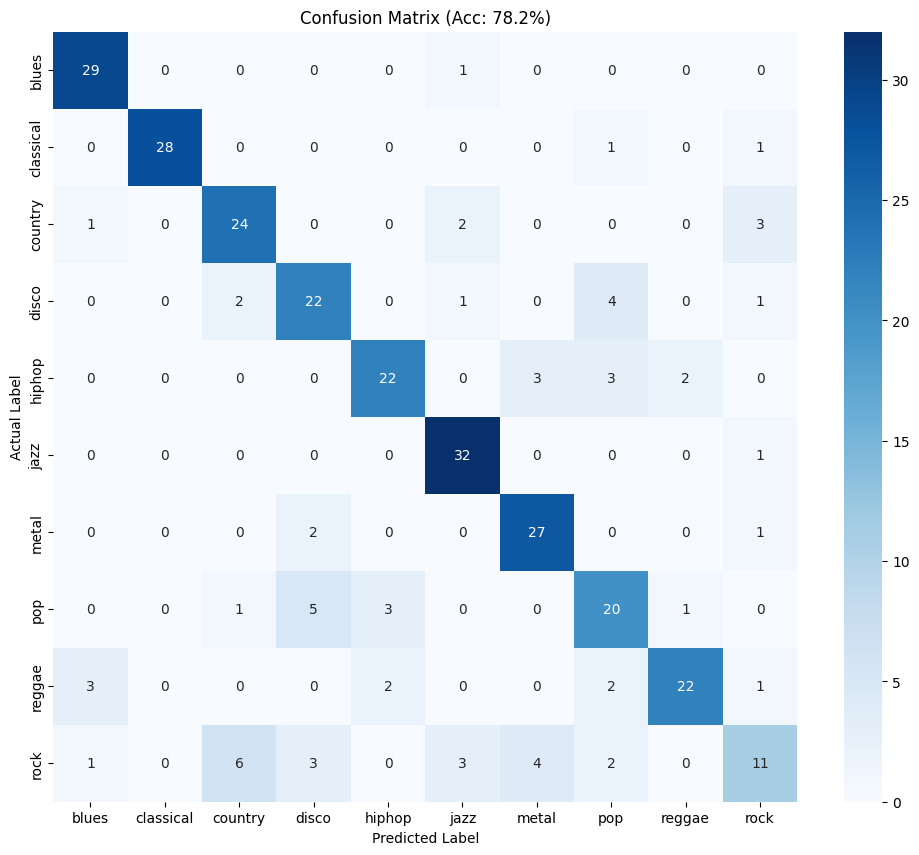


 Detailed Classification Report:

              precision    recall  f1-score   support

       blues       0.85      0.97      0.91        30
   classical       1.00      0.93      0.97        30
     country       0.73      0.80      0.76        30
       disco       0.69      0.73      0.71        30
      hiphop       0.81      0.73      0.77        30
        jazz       0.82      0.97      0.89        33
       metal       0.79      0.90      0.84        30
         pop       0.62      0.67      0.65        30
      reggae       0.88      0.73      0.80        30
        rock       0.58      0.37      0.45        30

    accuracy                           0.78       303
   macro avg       0.78      0.78      0.77       303
weighted avg       0.78      0.78      0.78       303



In [ ]:
# Cell 7: Visualizing Results
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get class names from the dataset
class_names = test_ds.classes

# 1. Compute Matrix
cm = confusion_matrix(y_true, y_pred)

# 2. Plot Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title(f'Confusion Matrix (Acc: {final_acc:.1f}%)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# 3. Print Detailed Report (Precision, Recall, F1-Score)
print("\n Detailed Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
# Cell 6: Final Test Evaluation (CPU/GPU Compatible)
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from ast_models import ASTModel
import os

# --- CONFIGURATION ---
BASE_WEIGHTS_PATH = "/content/drive/MyDrive/SSAST_Project/SSAST-Base-Patch-400.pth"
# Ensure this matches the file you actually want to test!
BEST_MODEL_PATH = "/content/drive/MyDrive/SSAST_Project/best_ssast_model_optimized.pth"
BATCH_SIZE = 4
# ---------------------

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# 1. Load Test Data
# (Using default dataset class)
test_ds = GTZAN_Metadata_Dataset("metadata/test.csv")
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# 2. Re-Initialize Model Architecture
print(f"Re-building model architecture...")
ssast_model = ASTModel(
    label_dim=527, input_fdim=128, input_tdim=1024,
    model_size='base', pretrain_stage=False,
    load_pretrained_mdl_path=BASE_WEIGHTS_PATH,
    fshape=16, tshape=16, fstride=10, tstride=10
)

# 3. Modify Head
if hasattr(ssast_model, 'mlp_head'):
    input_dim = ssast_model.mlp_head[1].in_features
    ssast_model.mlp_head[1] = nn.Linear(input_dim, 10)
else:
    ssast_model.head = nn.Linear(768, 10)

ssast_model = ssast_model.to(device)

# 4. Load Best Weights (Fixed for CPU)
if os.path.exists(BEST_MODEL_PATH):
    print(f"Loading weights from: {BEST_MODEL_PATH}")
    # [FIX]: Added map_location=device to handle CPU loading
    ssast_model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
else:
    print(f"Warning: {BEST_MODEL_PATH} not found. Using initialized weights.")

# 5. Run Evaluation
print(f"Evaluation on {len(test_ds)} Test Samples...")

ssast_model.eval()
correct = 0
total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)

        # Use Mixed Precision (only works on CUDA, so we disable it for CPU safety)
        if device.type == 'cuda':
            with torch.amp.autocast('cuda'):
                out = ssast_model(x, task='ft_avgtok')
        else:
            # CPU Fallback
            out = ssast_model(x, task='ft_avgtok')

        _, preds = out.max(1)
        total += y.size(0)
        correct += preds.eq(y).sum().item()

        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

final_acc = 100 * correct / total
print("-" * 30)
print(f"FINAL TEST ACCURACY: {final_acc:.2f}%")
print("-" * 30)

✅ Device: cpu
🔄 Re-building model architecture...
now load a SSL pretrained models from /content/drive/MyDrive/SSAST_Project/SSAST-Base-Patch-400.pth
pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=1212
📂 Loading weights from: /content/drive/MyDrive/SSAST_Project/best_ssast_model_optimized.pth
🧪 Evaluation on 303 Test Samples...
------------------------------
🏆 FINAL TEST ACCURACY: 77.56%
------------------------------
